# Resampling methods for model evaluation and attribute selection



In [74]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data preprocessing

In [7]:

data_path = "data/communities.data"
data = pd.read_csv(data_path, header=None, na_values=['?'])

# Reading attribute names from the .names file
def load_attribute_names(names_path):
    attribute_names = []
    with open(names_path, 'r') as f:
        for line in f:
            if line.startswith('@attribute'):
                attribute_name = line.split()[1]
                attribute_names.append(attribute_name)
    return attribute_names

names_path = "data/communities.names"
attribute_names = load_attribute_names(names_path)

data.columns = attribute_names

print(data.head())

# Number of Instances: 1994
# Number of Attributes: 128


   state  county  community        communityname  fold  population  \
0      8     NaN        NaN         Lakewoodcity     1        0.19   
1     53     NaN        NaN          Tukwilacity     1        0.00   
2     24     NaN        NaN         Aberdeentown     1        0.00   
3     34     5.0    81440.0  Willingborotownship     1        0.04   
4     42    95.0     6096.0    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20       0.06  

In [8]:
missing_values = data.isna().sum()
print(missing_values)

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64


In [9]:
# data = data.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1)
data = data.drop(data.columns[0:5], axis=1)

In [10]:
# Since there is only numeric data left - missing values => average of the feature
data = data.fillna(data.mean())

In [11]:
total_missing = data.isna().sum().sum()
print(f"Total missing values: {total_missing}")

Total missing values: 0


In [50]:
y = data['ViolentCrimesPerPop']
X = data.drop(columns=['ViolentCrimesPerPop'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # random_state = 42 to get the same split every time

## Cross Validation Method

Cross validation is a technique used to evaluate the performance of a model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds. This process is repeated multiple times, each time using a different fold as the validation set. Finally, the results from each validation step are averaged to produce a more robust estimate of the model’s performance. Cross validation is an important step in the machine learning process and helps to ensure that the model selected for deployment is robust and generalizes well to new data. 

Types of cross-validation:
1. Leave-One-Out CV: the model is trained on n−1 samples and tested on the one omitted sample, repeating this process for each data point in the dataset.
2. K-Fold CV: we split the dataset into k number of subsets (known as folds) then we perform training on the all the subsets but leave one subset for the evaluation of the trained model. In this method, we iterate k times with a different subset reserved for testing purpose each time.

In [51]:

def cross_validation(X, y, k=None):
    
    # Convert to numpy arrays for easier manipulation
    X = X.values
    y = y.values
    
    # Data shuffling
    indices = np.random.permutation(len(y))
    X = X[indices]
    y = y[indices]
    
    n = len(y)
    if k is None:
        k = len(y)
    fold_size = n // k
    errors = [] # the performance metric for each fold
    
    for i in range(k):
        start = i * fold_size
        end = start + fold_size if i < k-1 else n
        
        X_train = np.concatenate((X[:start], X[end:]), axis=0)
        y_train = np.concatenate((y[:start], y[end:]), axis=0)
        X_test = X[start:end]
        y_test = y[start:end]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        errors.append(mean_absolute_error(y_test, y_pred))
        
    return np.mean(errors)
    

In [52]:
cv_5_mse = cross_validation(X_train, y_train, k=5)
print('Average MSE using 5-fold CV', cv_5_mse)

Average MSE using 5-fold CV 0.10058378040835445


In [53]:
loocv_mse = cross_validation(X_train, y_train)
print('Average MSE using LOOCV', loocv_mse)

Average MSE using LOOCV 0.09926788946183598


## Forward feature selection

In [54]:
def forward_selection(X, y):
    selected_features = []
    remaining_features = list(X.columns)
    best_score = float('inf')
    
    while remaining_features:
        scores = []
        for feature in remaining_features:
            features = selected_features + [feature]
            X_subset = X[features]
            score = cross_validation(X_subset, y, k=5)
            scores.append((score, feature))
        
        scores.sort()
        best_new_score, best_feature = scores[0]
        
        if best_new_score < best_score:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_score = best_new_score
        else:
            break 
    
    return selected_features


In [55]:
selected_features = forward_selection(X_train, y_train)
selected_features

['PctIlleg',
 'PctKids2Par',
 'HousVacant',
 'racePctWhite',
 'agePct16t24',
 'PctLargHouseFam',
 'NumStreet',
 'numbUrban',
 'population',
 'pctUrban',
 'PctPolicMinor',
 'householdsize']

In [76]:
mean_error = cross_validation(X_train[selected_features], y_train, k=5)
print('MSE score:', mean_error)

MSE score: 0.09652620276815008


In [77]:
# Testing the model on the independent test set

final_model = LinearRegression()
final_model.fit(X_train[selected_features], y_train)

y_test_pred = final_model.predict(X_test[selected_features])
test_error = mean_squared_error(y_test, y_test_pred)

print(f"Cross-Validation Mean Error: {mean_error}")
print(f"Independent Test Set Error: {test_error}")

Cross-Validation Mean Error: 0.09652620276815008
Independent Test Set Error: 0.01724686465755154


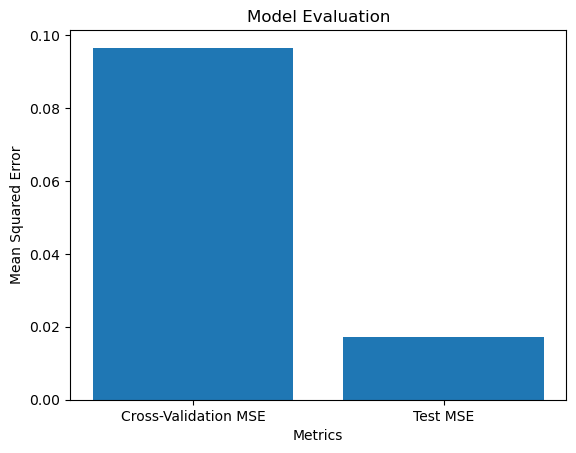

In [78]:
metrics = ['Cross-Validation MSE', 'Test MSE']
values = [mean_error, test_error]

plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Mean Squared Error')
plt.title('Model Evaluation')
plt.show()


## The bootstrap method
Applied to the train set generating 1000 different train sets and training 1000 different linear models.

In [56]:
def bootstrap(X, y, num_samples=1000):
    bootstrap_metrics = []
    
    for _ in range(num_samples):
        # Sample with replacement
        X_sample, y_sample = resample(X, y, random_state=0)
        
        # Fit model and evaluate
        model = LinearRegression()
        model.fit(X_sample, y_sample)
        y_pred = model.predict(X_sample)
        metric = mean_absolute_error(y_sample, y_pred)
        bootstrap_metrics.append(metric)
    
    # Calculate confidence interval
    lower = np.percentile(bootstrap_metrics, 2.5)
    upper = np.percentile(bootstrap_metrics, 97.5)
    
    return lower, upper


### Confidence intervals
For selected metrics